# Metapath Rank Comparison
Compare the rankings the unsupervised methods in hetmech assign to different epilepsy/drug metapaths to the supervised ones from rephetio

In [1]:
import configparser
import math

import pandas
import psycopg2
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
parser = configparser.ConfigParser()
parser.read('database.ini')

db_password = parser['psql']['password']

In [7]:
epilepsy_id = 'DOID:1826'

# Get top ten most important metapaths for epilepsy (which are all compound-disease pairs)
query = f'''SELECT outer_pc.dwpc AS dwpc, outer_pc.p_value AS p_value, outer_pc.metapath_id AS metapath_id, 
                top_ids.source_name AS source_name, top_ids.source_identifier AS source_identifier, 
                top_ids.target_name AS target_name, top_ids.target_identifier AS target_identifier
FROM 
    (SELECT dwpc, p_value, metapath_id, source_id, target_id, n1.name AS source_name, n1.identifier AS source_identifier,
            n2.name AS target_name, n2.identifier AS target_identifier
     FROM dj_hetmech_app_pathcount pc 
     JOIN dj_hetmech_app_node join_node  
         ON pc.target_id=join_node.id OR pc.source_id=join_node.id 
     JOIN dj_hetmech_app_node n1 
         ON pc.source_id = n1.id 
     JOIN dj_hetmech_app_node n2 
         ON pc.target_id = n2.id     
     WHERE join_node.identifier='{epilepsy_id}' 
     ORDER BY pc.p_value) AS top_ids 
JOIN dj_hetmech_app_pathcount outer_pc 
     ON (top_ids.source_id = outer_pc.source_id AND 
         top_ids.target_id = outer_pc.target_id) OR 
         (top_ids.source_id = outer_pc.target_id AND 
         top_ids.target_id = outer_pc.source_id)
ORDER BY outer_pc.p_value;
'''

connection = psycopg2.connect(host = 'hetmech-db-dev.cobepk65dd7j.us-east-1.rds.amazonaws.com', 
                              database = 'dj_hetmech', user = 'read_only_user', password = db_password)

metapaths = pandas.read_sql(query, connection)

In [18]:
metapaths = metapaths.sort_values(by=['source_name', 'metapath_id'])

# Ensure that you only have one copy of each (source_name, metapath_id) pair
metapaths = metapaths.drop_duplicates(subset=['source_name', 'metapath_id'])

# Remove any rows with NaN values
metapaths = metapaths.dropna()

min_p_value = metapaths[metapaths.p_value != 0].p_value.min()

metapaths.loc[metapaths.p_value == 0, 'p_value'] = min_p_value

metapaths['neg_log_p_value'] = metapaths.p_value.apply(lambda x: -math.log10(x))

metapaths.head()

,dwpc,p_value,metapath_id,source_name,source_identifier,target_name,target_identifier,neg_log_p_value
14783,3.870881,0.010753,CbGaD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,1.968488
11837,2.771277,0.006504,CbGdAlD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,2.186818
8974,2.743718,0.003349,CcSEcCtD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,2.475071
38224,4.085647,0.078231,CtDdGaD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,1.106620
31170,2.131258,0.050733,CbGdAlD,Abiraterone,DB05812,epilepsy syndrome,DOID:1826,1.294707


In [19]:
supervised_df = pandas.read_csv('https://github.com/dhimmel/learn/raw/8792c2e408e790cd8d77adb34d013961f4d5c4f0/prediction/predictions/metapath-contribution.tsv.bz2',
                                                sep='\t', compression='bz2')

In [21]:
supervised_df = supervised_df[supervised_df['disease_id'] == epilepsy_id]

supervised_df.head()

,compound_id,disease_id,CbGdCrCtD,CrCbGaD,CbGeAlD,CbGpPWpGaD,CpDpCtD,CcSEcCtD,CrCrCtD,CtDrD,CrCtD,CiPCiCtD,CbGaD,CbGbCtD
72286,DB01048,DOID:1826,0.0,0.000000,0.003461,0.06024,0.0,0.1850,0.0,0.0,0.0,0.0,0.6417,0.1096
72287,DB05812,DOID:1826,0.0,0.002036,0.003963,0.07116,0.0,0.1611,0.0,0.0,0.0,0.0,0.2532,0.5086
72288,DB00659,DOID:1826,0.0,0.000000,0.046480,0.08458,0.0,0.1140,0.0,0.0,0.0,0.0,0.3596,0.3953
72289,DB00284,DOID:1826,0.0,0.000000,0.310800,0.30470,0.0,0.3845,0.0,0.0,0.0,0.0,0.0000,0.0000
72290,DB01193,DOID:1826,0.0,0.002377,0.003625,0.08410,0.0,0.2401,0.0,0.0,0.0,0.0,0.3447,0.3251


In [22]:
reformatted_supervised_df = pandas.melt(supervised_df, id_vars=['compound_id', 'disease_id'], 
                                        var_name='metapath_id', value_name='metapath_weight')

reformatted_supervised_df.head()

,compound_id,disease_id,metapath_id,metapath_weight
0,DB01048,DOID:1826,CbGdCrCtD,0.0
1,DB05812,DOID:1826,CbGdCrCtD,0.0
2,DB00659,DOID:1826,CbGdCrCtD,0.0
3,DB00284,DOID:1826,CbGdCrCtD,0.0
4,DB01193,DOID:1826,CbGdCrCtD,0.0


In [26]:
merged_df = metapaths.merge(reformatted_supervised_df, left_on=['metapath_id', 'source_identifier', 'target_identifier'],
                            right_on=['metapath_id', 'compound_id', 'disease_id'])
merged_df.head()

,dwpc,p_value,metapath_id,source_name,source_identifier,target_name,target_identifier,neg_log_p_value,compound_id,disease_id,metapath_weight
0,3.870881,0.010753,CbGaD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,1.968488,DB01048,DOID:1826,0.6417
1,2.743718,0.003349,CcSEcCtD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,2.475071,DB01048,DOID:1826,0.1850
2,2.431818,0.004470,CcSEcCtD,Abiraterone,DB05812,epilepsy syndrome,DOID:1826,2.349703,DB05812,DOID:1826,0.1611
3,4.068102,0.018192,CbGaD,Acamprosate,DB00659,epilepsy syndrome,DOID:1826,1.740126,DB00659,DOID:1826,0.3596
4,4.486098,0.000116,CbGbCtD,Acamprosate,DB00659,epilepsy syndrome,DOID:1826,3.934527,DB00659,DOID:1826,0.3953


Text(0,0.5,'Rephetio Metapath Weight')

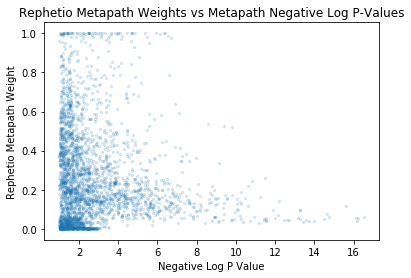

In [35]:
plt.scatter(merged_df.neg_log_p_value, merged_df.metapath_weight, alpha=.15, s=5)

plt.title('Rephetio Metapath Weights vs Metapath Negative Log P-Values')
plt.xlabel('Negative Log P Value')
plt.ylabel('Rephetio Metapath Weight')


In [37]:
scipy.stats.kendalltau(merged_df.neg_log_p_value, merged_df.metapath_weight)

KendalltauResult(correlation=0.012442494759812947, pvalue=0.2991016718196584)